### IMPORT DELLE VARIE LIBRERIE

- **pandas** per l'utilizzo dei dataframe
- **nltk** per il preprocessamento dei dati (tokenizzazione, rimozione stop word e punteggiatura, lemmatizzazione)
- **sklearn** per lo split dei dati train/test, realizzazione della matrice tf-idf e cross-validazione
- **xgboost** per il modello di predizione

In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cuomo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### ANALISI DEL DATASET

In [2]:
df = pd.read_csv('mbti.csv')

In [3]:
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [4]:
df.shape

(8675, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


Text(0.5, 1.0, 'distribuzione degli utenti per ogni tipo di personalità')

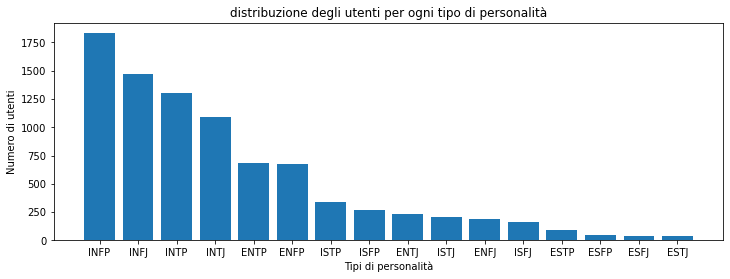

In [6]:
total = df.groupby(['type']).count().sort_values(by='posts', ascending=False)

plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)

plt.xlabel('Tipi di personalità')
plt.ylabel('Numero di utenti')
plt.title('distribuzione degli utenti per ogni tipo di personalità')

### SPLIT COLONNA TYPE IN 4 COLONNE AGGIUNTIVE

In [7]:
df['IE'] = df.apply(lambda row: 1 if "I" in row["type"] else "0",  axis=1)
df['NS'] = df.apply(lambda row: 1 if "N" in row["type"] else "0",  axis=1)
df['TF'] = df.apply(lambda row: 1 if "T" in row["type"] else "0",  axis=1)
df['JP'] = df.apply(lambda row: 1 if "J" in row["type"] else "0",  axis=1)

df['IE']=df['IE'].astype(int)
df['NS']=df['NS'].astype(int)
df['TF']=df['TF'].astype(int)
df['JP']=df['JP'].astype(int)

df = df.drop('type', axis=1)

In [8]:
df.head()

,posts,IE,NS,TF,JP
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,'You're fired.|||That's another silly misconce...,0,1,1,1


### PRE-PROCESSING DEL CAMPO posts
- tokenizzazione
- stemming
- eliminazione stop words
- conversione in minuscolo

In [9]:
#tokenizzazione

nltk.download('words')
import nltk
words = set(nltk.corpus.words.words())

f = lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words)
df['posts'] = df['posts'].apply(f)
df

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\cuomo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


,posts,IE,NS,TF,JP
0,watch v media and watch v not top ten watch v ...,1,1,0,1
1,I m finding the lack of me in these very alarm...,0,1,1,0
2,Good one watch v Of course to which I say I kn...,1,1,1,0
3,Dear I our conversation the other day Esoteric...,1,1,1,1
4,You re fired That s another silly misconceptio...,0,1,1,1
...,...,...,...,...,...
8670,watch v just because I always think of as Fi f...,1,0,0,0
8671,So if this thread already someplace else which...,0,1,0,0
8672,So many when i do these I would take the purpl...,1,1,1,0
8673,I am very right now when it comes to wanting I...,1,1,0,0


In [10]:
#eliminazione stop word

f = lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() not in stop_words)
df['posts'] = df['posts'].apply(f)
df

,posts,IE,NS,TF,JP
0,watch v media watch v top ten watch v life exp...,1,1,0,1
1,finding lack alarming Sex boring position ofte...,0,1,1,0
2,Good one watch v course say know blessing curs...,1,1,1,0
3,Dear conversation day Esoteric nature universe...,1,1,1,1
4,fired another silly misconception approaching ...,0,1,1,1
...,...,...,...,...,...
8670,watch v always think Fi reason watch v Especia...,1,0,0,0
8671,thread already someplace else forum heck delet...,0,1,0,0
8672,many would take purple pill Pick winning lotte...,1,1,1,0
8673,right comes wanting honestly maternal instinct...,1,1,0,0


In [11]:
#lemmatization

lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet 

f = lambda x: " ".join(lemmatizer.lemmatize(y, wordnet.VERB) for y in x.split())

df['posts'] = df['posts'].apply(f)
df

,posts,IE,NS,TF,JP
0,watch v media watch v top ten watch v life exp...,1,1,0,1
1,find lack alarm Sex bore position often exampl...,0,1,1,0
2,Good one watch v course say know bless curse a...,1,1,1,0
3,Dear conversation day Esoteric nature universe...,1,1,1,1
4,fire another silly misconception approach logi...,0,1,1,1
...,...,...,...,...,...
8670,watch v always think Fi reason watch v Especia...,1,0,0,0
8671,thread already someplace else forum heck delet...,0,1,0,0
8672,many would take purple pill Pick win lottery w...,1,1,1,0
8673,right come want honestly maternal instinct wha...,1,1,0,0


### CREAZIONE MATRICE TF-IDF

In [12]:
v = TfidfVectorizer(lowercase=True, 
                            stop_words='english', 
                            max_features=800,
                            min_df=4,
                            max_df=0.5)

x = v.fit_transform(df['posts'])

tf_idf = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
res = pd.concat([df, tf_idf], axis=1).drop("posts", axis=1)
res

,IE,NS,TF,JP,ability,able,absolutely,accept,account,accurate,...,write,wrong,ya,yea,yeah,year,yep,yesterday,young,younger
0,1,1,0,1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.120025,0.000000,0.000000,0.000000,0.112649,0.0,0.000000,0.000000
1,0,1,1,0,0.000000,0.052433,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.048719,0.000000,0.0,0.000000,0.000000
2,1,1,1,0,0.181804,0.063060,0.151764,0.000000,0.0,0.091007,...,0.052490,0.000000,0.000000,0.000000,0.000000,0.058593,0.000000,0.0,0.000000,0.000000
3,1,1,1,1,0.000000,0.110251,0.000000,0.075304,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.045272,0.000000,0.000000,0.0,0.000000,0.000000
4,0,1,1,1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.045696,0.050045,0.000000,0.000000,0.000000,0.051010,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,1,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.082311
8671,0,1,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.197594,0.000000,0.000000,0.000000,0.077981,0.000000,0.000000,0.0,0.000000,0.000000
8672,1,1,1,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.045828,0.050189,0.094232,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8673,1,1,0,0,0.000000,0.082401,0.000000,0.000000,0.0,0.000000,...,0.034294,0.000000,0.000000,0.000000,0.101508,0.000000,0.000000,0.0,0.000000,0.000000


### PCA DELLA TF-IDF MATRIX

In [13]:
x = res.drop('IE',axis=1).drop('NS',axis=1).drop('TF',axis=1).drop('JP',axis=1)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


"""
principalDf = pd.concat([principalDf, df[['IE']]], axis = 1)
principalDf = pd.concat([principalDf, df[['NS']]], axis = 1)
principalDf = pd.concat([principalDf, df[['TF']]], axis = 1)
principalDf = pd.concat([principalDf, df[['JP']]], axis = 1)
"""
principalDf

,principal component 1,principal component 2
0,-0.087494,0.162294
1,0.091387,0.008583
2,-0.001074,0.003036
3,0.120060,-0.072742
4,-0.042948,0.006269
...,...,...
8670,-0.055624,0.082701
8671,-0.011728,0.083951
8672,-0.070053,0.001224
8673,-0.051592,-0.108002


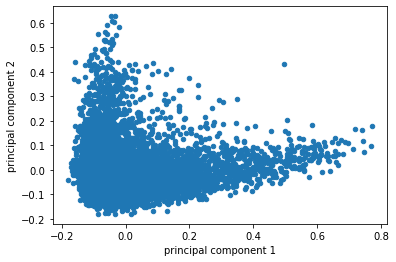

In [14]:
ax1 = principalDf.plot.scatter(x='principal component 1',y='principal component 2')

### SPLIT TRAIN AND TEST, ADDESTRAMENTO E TEST

	IE
accuratezza:0.7752161383285303


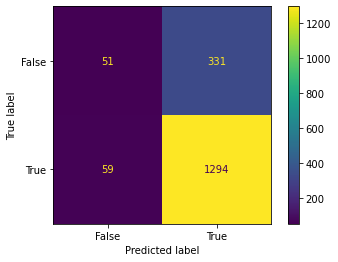

	NS
accuratezza:0.8570605187319885


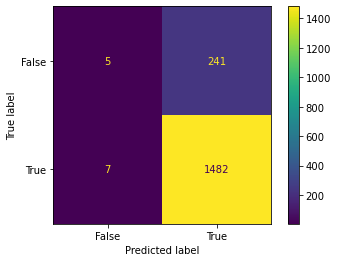

	TF
accuratezza:0.7204610951008645


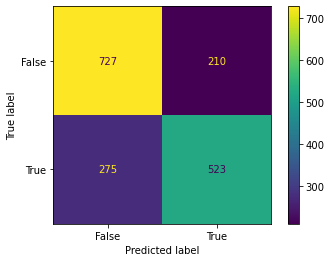

	JP
accuratezza:0.6414985590778098


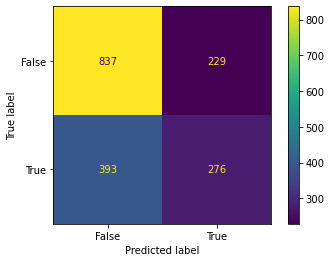

In [15]:
lst_target = ['IE', 'NS', 'TF', 'JP']
X = res.drop('IE',axis=1).drop('NS',axis=1).drop('TF',axis=1).drop('JP',axis=1)

for target in lst_target:
    y = res.loc[:, [target]].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = xgboost.XGBClassifier(n_estimators=200, learning_rate=0.2, max_depth=6,eval_metric='rmse')
    
    XGB=model.fit(X_train,y_train)
    prediction=XGB.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, prediction)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    
    print('================\n\t'+target+'\naccuratezza:'+str(accuracy_score(y_test, prediction))+'\n================')
    cm_display.plot()
    plt.show()

### Tuning dei parametri

In [16]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [17]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [18]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)


In [ ]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


In [ ]:
grid_search.best_estimator_